## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import model_metrics

print(model_metrics.__version__)

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from model_tuner import Model, loadObjects
import model_tuner

from ucimlrepo import fetch_ucirepo
from eda_toolkit import ensure_directory
from sklearn.metrics import roc_curve
from model_metrics import (
    summarize_model_performance,
    show_calibration_curve,
    show_confusion_matrix,
    show_roc_curve,
    roc_feature_plot,
    pr_feature_plot,
    show_pr_curve,
    show_lift_chart,
    show_gain_chart,
    show_ks_curve,
    plot_threshold_metrics,
)

0.0.2a


## Set Model Path

In [2]:
print(f"Model Metrics version: {model_metrics.__version__}")
print(f"Model Metrics authors: {model_metrics.__author__} \n")

## Define base paths
## `base_path`` represents the parent directory of your current working directory
base_path = os.path.join(os.pardir)
## Go up one level from 'notebooks' to the parent directory, then into the
## 'results' folder

model_path = os.path.join(os.pardir, "model_files/results")
data_path = os.path.join(os.pardir, "model_files")
image_path_png = os.path.join(data_path, "images", "png_images")
image_path_svg = os.path.join(data_path, "images", "svg_images")

# Use the function to ensure the 'data' directory exists
ensure_directory(model_path)
ensure_directory(image_path_png)
ensure_directory(image_path_svg)

Model Metrics version: 0.0.2a
Model Metrics authors: Leonid Shpaner 

Directory exists: ../model_files/results
Directory exists: ../model_files/images/png_images
Directory exists: ../model_files/images/svg_images


## Load The Model Object and Test Data

In [3]:
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features

In [4]:
model_lr = loadObjects(os.path.join(model_path, "LogisticRegression.pkl"))
model_dt = loadObjects(os.path.join(model_path, "DecisionTreeClassifier.pkl"))
model_rf = loadObjects(os.path.join(model_path, "RandomForestClassifier.pkl"))


X_test = pd.read_parquet(os.path.join(data_path, "X_test.parquet"))
y_test = pd.read_parquet(os.path.join(data_path, "y_test.parquet"))

Object loaded!
Object loaded!
Object loaded!


In [5]:
X

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States


In [6]:
X_test_2 = X_test.join(
    X[["sex", "race", "relationship", "occupation", "workclass", "education"]]
)

In [7]:
X_test_2

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,sex,race,relationship,occupation,workclass,education
index,,,,,,,,,,,,
4384,27,181667,9,5013,0,46,Male,White,Husband,Machine-op-inspct,Private,HS-grad
16656,51,171409,10,0,0,40,Male,White,Husband,Transport-moving,Private,Some-college
22898,84,127184,3,0,0,20,Male,White,Husband,?,?,5th-6th
15632,60,40856,11,0,0,46,Male,White,Husband,Craft-repair,Private,Assoc-voc
2301,45,158685,9,0,0,40,Female,White,Not-in-family,Sales,Private,HS-grad
...,...,...,...,...,...,...,...,...,...,...,...,...
32955,41,155041,9,3418,0,40,Female,White,Own-child,NaN,NaN,HS-grad
36943,58,115439,14,0,0,40,Male,White,Husband,Sales,Self-emp-not-inc,Masters
40470,42,276218,13,0,0,38,Female,White,Unmarried,Exec-managerial,Private,Bachelors


## Set The Desired Naming Conventions

In [8]:
pipelines_or_models = [
    model_lr["model"].estimator,
    model_rf["model"].estimator,
    model_dt["model"].estimator,
]

# Model titles
model_titles = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
]

AUC for Logistic Regression: 0.96


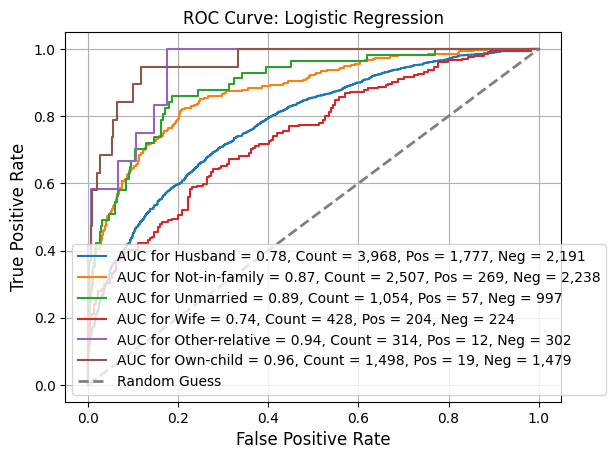

AUC for Decision Tree Classifier: 0.94


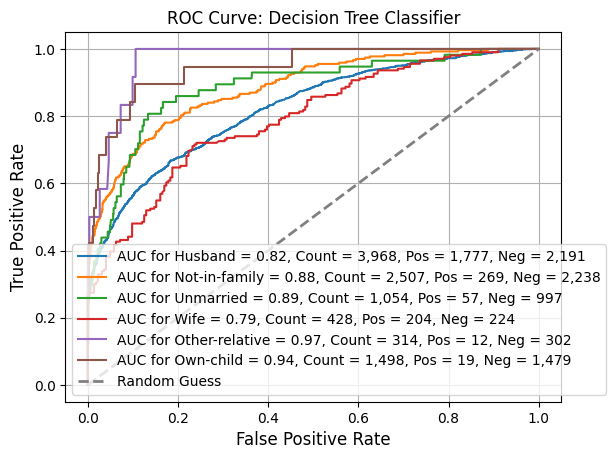

AUC for Random Forest Classifier: 0.87


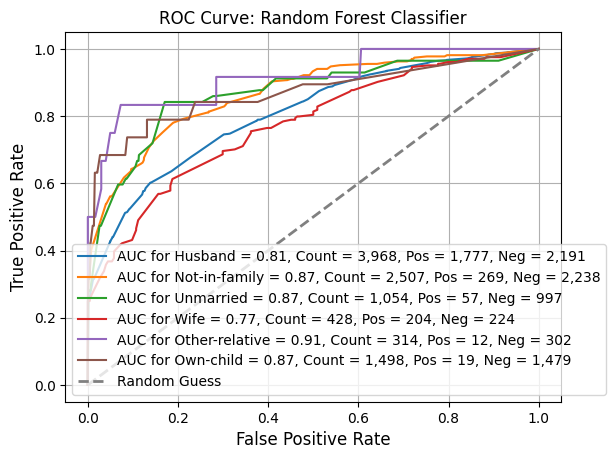

In [10]:
# Plot ROC curves
show_roc_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    # title = "",
    title=None,
    model_titles=model_titles,
    decimal_places=2,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(8, 10),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["relationship"],
)

Average Precision for Logistic Regression: 0.42


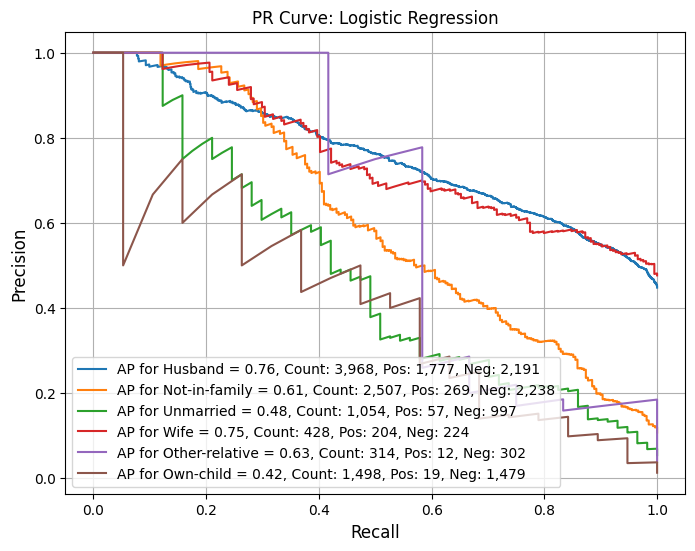

Average Precision for Decision Tree Classifier: 0.48


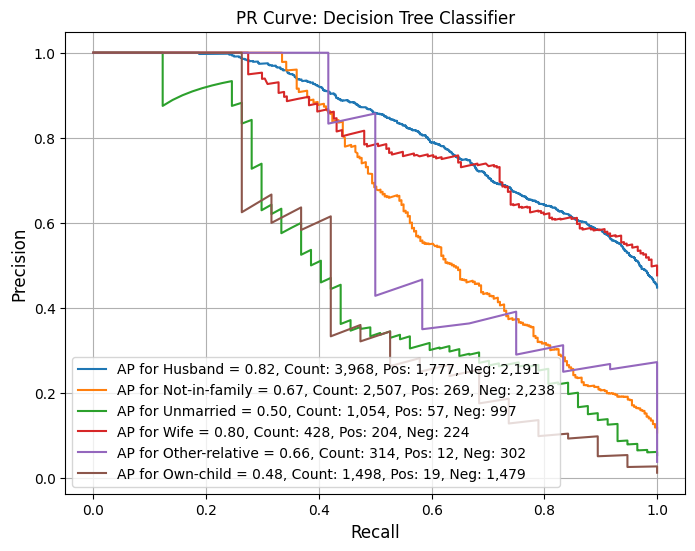

Average Precision for Random Forest Classifier: 0.41


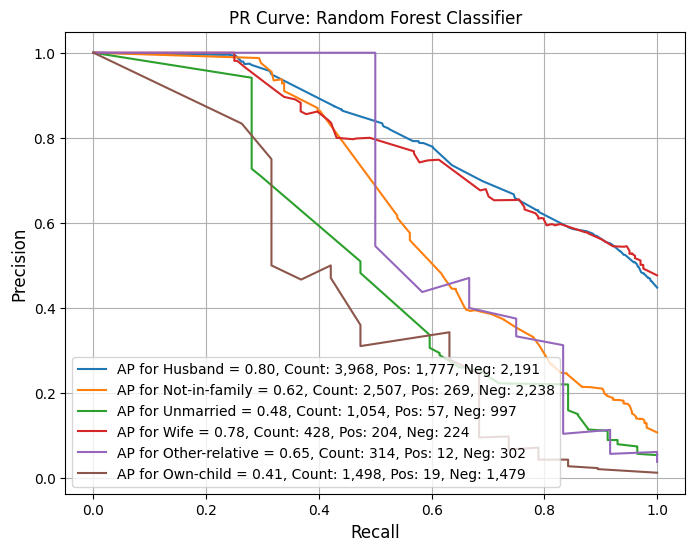

In [11]:
# Plot ROC curves
show_pr_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    # title = "",
    title=None,
    model_titles=model_titles,
    decimal_places=2,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(8, 10),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["relationship"],
)

## Summarize Model Performance

In [ ]:
model_summary = summarize_model_performance(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    # model_threshold=thresholds,
    return_df=True,
    # custom_threshold=0.7,
)

model_summary

In [ ]:
model_titles

In [ ]:
model_titles[1]

In [ ]:
# Call the function
roc_feature_plot(
    models=pipelines_or_models[1],
    X=X_test,
    y=y_test,
    feature_names=X_test.columns.to_list(),
    model_titles=model_titles[1],
    # title="sd",
    save_plot=True,
    image_path_png="roc_features.png",
    linestyle_kwgs={"color": "red", "linestyle": "--", "linewidth": 2},
    # decimal_places=2,
    # curve_kwgs={
    #     "age": {
    #         "color": "blue",
    #         "linestyle": "-",
    #         "linewidth": 2,
    #     },  # Style for sepal length
    #     "fnlwgt": {
    #         "color": "black",
    #         "linestyle": "--",
    #         "linewidth": 2,
    #     },  # Style for sepal width
    # },
    # gridlines=False,
    # title="",
)

In [ ]:
# Plot PR curves for individual features with feature-specific styling
pr_feature_plot(
    models=pipelines_or_models[1],
    X=X_test,
    y=y_test,
    feature_names=X_test.columns.to_list(),
    model_titles=model_titles[1],
    # title="sd",
    save_plot=True,
    image_path_png="roc_features.png",
    linestyle_kwgs={"color": "red", "linestyle": "--", "linewidth": 2},
    # decimal_places=2,
    # curve_kwgs={
    #     "age": {
    #         "color": "blue",
    #         "linestyle": "-",
    #         "linewidth": 2,
    #     },  # Style for sepal length
    #     "fnlwgt": {
    #         "color": "black",
    #         "linestyle": "--",
    #         "linewidth": 2,
    #     },  # Style for sepal width
    # },
    # gridlines=False,
    # title="",
)

In [ ]:
X

In [ ]:
X_test

In [ ]:
X_test_2 = X_test.join(X[["sex", "race"]])

In [ ]:
X

In [ ]:
X_test_2

In [ ]:
# from sklearn.datasets import make_classification
# import pandas as pd
# from sklearn.linear_model import LogisticRegression

# # Generate sample data with a categorical "Sex" feature
# X, y = make_classification(
#     n_samples=1000, n_features=4, n_informative=2, n_classes=2, random_state=42
# )
# X_df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(4)])
# X_df["Sex"] = pd.Series(
#     ["Male"] * 500 + ["Female"] * 500, dtype="category"
# )  # Example categorical data

# # Train a model (using numeric features for simplicity, but the function will handle "Sex")
# model = LogisticRegression(max_iter=200)
# model.fit(X_df.drop("Sex", axis=1), y)  # Train on numeric features

# # Define curve_kwgs for specific categorical values
# curve_kwgs = {
#     "Sex_Male": {"color": "blue", "linestyle": "-", "linewidth": 2},
#     "Sex_Female": {"color": "orange", "linestyle": "--", "linewidth": 2},
# }

# # Plot ROC curves for the "Sex" categorical feature with custom styling and class counts
# show_roc_cat_features(
#     models=[model],
#     X=X_df,
#     y=y,
#     categorical_feature_name="Sex",
#     model_titles=["Logistic Regression"],
#     curve_kwgs=curve_kwgs,  # Apply value-specific styling
#     save_plot=True,
#     image_path_png="roc_sex_feature.png",
#     decimal_places=3,  # Specify decimal places for AUC
#     smooth_curves=True,  # Enable smoothing for cleaner curves
# )

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import textwrap
# from sklearn.metrics import roc_curve, roc_auc_score
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression

# # Load Iris dataset (for binary classification, e.g., class 0 vs. rest)
# iris = load_iris()
# X = pd.DataFrame(iris.data, columns=iris.feature_names)
# y = (iris.target > 0).astype(int)  # Binary classification: 0 vs. 1+2

# # Create a categorical feature from 'sepal length (cm)' for demonstration
# X["sepal_length_category"] = pd.qcut(
#     X["sepal length (cm)"], q=3, labels=["low", "medium", "high"]
# )

# # Train a model
# model = LogisticRegression(max_iter=200)
# model.fit(X.drop("sepal_length_category", axis=1), y)  # Train on numeric features

# # Define curve_kwgs for specific categorical values
# # curve_kwgs = {
# #     "sepal_length_category_low": {"color": "blue", "linestyle": "-", "linewidth": 2},
# #     "sepal_length_category_medium": {
# #         "color": "orange",
# #         "linestyle": "--",
# #         "linewidth": 2,
# #     },
# #     "sepal_length_category_high": {"color": "green", "linestyle": "-.", "linewidth": 2},
# # }

# # Measure runtime and plot ROC curves for the categorical feature
# import time

# start_time = time.time()

# show_roc_cat_features(
#     models=[model],
#     X=X,
#     y=y,
#     categorical_feature_name="sepal_length_category",
#     model_titles=["Logistic Regression"],
#     # curve_kwgs=curve_kwgs,
#     save_plot=True,
#     image_path_png="roc_sepal_length_category.png",
#     decimal_places=3,
# )

# end_time = time.time()
# print(f"Runtime: {end_time - start_time:.2f} seconds")

In [ ]:
# show_roc_cat_features(
#     models=pipelines_or_models[1],
#     X=X_test_2,
#     y=y_test,
#     categorical_feature_name="sex",
#     model_titles=model_titles[1],
#     # curve_kwgs=curve_kwgs,  # Apply value-specific styling
#     # save_plot=True,
#     # image_path_png="roc_sex_feature.png",
#     decimal_places=3,  # Specify decimal places for AUC
# )

In [ ]:
# Example: Running KS Curve with a trained model
show_ks_curve(
    models=pipelines_or_models[0],  # Your trained model object
    X=X_test,  # Test dataset
    y=y_test,  # True labels
    title="Kolmogorov-Smirnov Curves",
    save_plot=False,
    text_wrap=50,
    curve_kwgs={"linewidth": 2},
    linestyle_kwgs={"color": "red", "linestyle": "--", "linewidth": 2},
    figsize=(8, 6),
    label_fontsize=12,
    model_titles=model_titles,
    tick_fontsize=10,
    gridlines=True,
)

## Plot The Calibration Curve

In [ ]:
# Plot calibration curves in overlay mode
show_calibration_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    # model_titles=model_titles,
    overlay=True,
    # title="Calibration Curves",
    text_wrap=40,
    figsize=(10, 6),
    label_fontsize=14,
    tick_fontsize=9,
    bins=10,
    show_brier_score=True,
    grid=False,
    # gridlines=False,
    linestyle_kwgs={"color": "black"},
    title="",
)

## Plot The Confusion Matrix

In [ ]:
show_confusion_matrix(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    cmap="Blues",
    text_wrap=40,
    # title="Custom",
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    grid=True,
    n_cols=3,
    n_rows=1,
    figsize=(4, 4),
    show_colorbar=False,
    label_fontsize=14,
    tick_fontsize=12,
    inner_fontsize=10,
    class_report=True,
    # custom_threshold=0.5,
    # labels=False,
)

## Plot ROC AUC Curve

In [ ]:
# Plot ROC curves
show_roc_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    title=None,
    model_titles=model_titles,
    decimal_places=6,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    figsize=(8, 6),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

In [ ]:
# Plot ROC curves
show_pr_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    title=None,
    model_titles=model_titles,
    decimal_places=3,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    figsize=(10, 10),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

In [ ]:
X_test.columns.to_list()

In [ ]:
# Call the function
roc_feature_plot(
    models=pipelines_or_models[0],
    X=X_test,
    y=y_test,
    feature_names=X_test.columns.to_list(),
    model_titles=model_titles,
    save_plot=False,
    image_path_png=image_path_png,
)

## Precision-Recall Curve

In [ ]:
show_pr_curve(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    # x_label="Hello",
    model_titles=model_titles,
    decimal_places=3,
    # title="Custom",
    overlay=False,
    n_cols=3,
    grid=True,
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    figsize=(10, 4),
    # tick_fontsize=16,
    # label_fontsize=16,
    # grid=True,
    # gridlines=False,
)

## Lift Chart

In [ ]:
# Plot Lift chart
show_lift_chart(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    model_titles=model_titles,
    save_plot=True,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     # "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    linestyle_kwgs={"color": "grey", "linestyle": "--"},
    grid=True,
    n_cols=3,
    figsize=(10, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

## Gain Chart

In [ ]:
# Plot Gain chart
show_gain_chart(
    models=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    model_titles=model_titles,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     # "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "black", "linestyle": "-"},
    save_plot=True,
    grid=True,
    n_cols=3,
    figsize=(10, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

In [ ]:
model_summary = summarize_model_performance(
    model=pipelines_or_models[0],
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    # model_threshold=thresholds,
    return_df=True,
    custom_threshold=0.7811,
)

model_summary

In [ ]:
# Example usage with a trained model
plot_threshold_metrics(
    pipelines_or_models[0],
    X_test,
    y_test,
    # figsize=(6, 6),
    # gridlines=False,
    # baselines=False,
    baseline_kwgs={
        "color": "purple",
        "linestyle": "--",
        # "alpha": 0.7,
        "linewidth": 0.8,
    },
    curve_kwgs={
        "linestyle": "-",
        # "alpha": 0.1,
        "linewidth": 1.25,
    },
    lookup_metric="precision",
    lookup_value=0.879,
    # title="Threshold Metrics for Model X",
    # decimal_places=2,
    # label_fontsize=10,
    # tick_fontsize=8,
)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Example dataset
# np.random.seed(42)
# X = pd.DataFrame(
#     {
#         "Feature 1": np.random.rand(100),
#         "Feature 2": np.random.rand(100),
#         "Feature 3": np.random.rand(100),
#     }
# )
# y = pd.DataFrame(np.random.randint(0, 2, size=(100, 1)))  # ✅ Ensuring y is a DataFrame

# # Split dataset
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# # Define models
# models = [
#     LogisticRegression(solver="liblinear"),
#     RandomForestClassifier(n_estimators=50),
# ]

In [ ]:
# Call the function
roc_feature_plot(
    models=pipelines_or_models[0],
    X=X_test,
    y=y_test,
    feature_names=X_test.columns.to_list(),
    model_titles=["Logistic Regression"],
    save_plot=True,
    image_path_png="roc_features.png",
)